In [2]:
from prometheus_pandas import query
import datetime
import time
import pandas as pd
import numpy as np # for calculating standard deviation and mean
#import scipy.stats as sp # for calculating standard error

ts = datetime.datetime.now()
url = 'http://localhost:8080/prometheus/'

tenants = [1, 5,10,50, 100]

# this selects 100 metrics per tenant
selectors = [
    '{bench_replica=~"replica-000.."}',                                     # returns 10000
    '{bench_replica=~"replica-000[98]."}',                                  # returns  2000
    '{bench_replica=~"replica-0009."}',                                     # returns  1000
    '{bench_replica=~"replica-0009[78]"}',                                  # returns   200
    '{bench_replica=~"replica-00098"}',                                     # returns   100 
    '{bench_replica=~"replica-00099",label_01=~"label_value_01-[78]."}',    # returns    20 
    '{bench_replica=~"replica-00099",label_01=~"label_value_01-8."}',       # returns    10 
    '{bench_replica=~"replica-00098",label_01=~"label_value_01-8[01]"}',    # returns     2 
    '{bench_replica=~"replica-00098",label_01=~"label_value_01-81"}',       # returns     1 
] 

df = pd.DataFrame({
    "tenants": pd.Series([], dtype="int"),
    "duration": pd.Series([], dtype="float64"),
    "result":  pd.Series([], dtype="float64"),
    "version": pd.Series([], dtype="str"),
})

def measure(name, selectors):
    durations = []
    results = []
    for idx, t in enumerate(tenants):
        orgID = "|".join([str(x) for x in range(100, 100+t)]) 

        start = time.time()
        p = query.Prometheus(url)
        p.http.headers.update({'x-scope-orgid': orgID})
        samples = p.query('count(%s)' % selectors[idx], ts)
        duration = time.time()-start
        results.append([t, duration, samples, name])
    return pd.DataFrame(results,columns=["tenants","duration","result","name"], index=tenants)


In [5]:
results_10000 = [measure('10000', selectors[:5]) for x in range(0,10)]

In [6]:
results_1000  = [measure('1000', selectors[2:7]) for x in range(0,10)]

In [7]:
results_100  = [measure('100', selectors[4:9]) for x in range(0,10)]

None


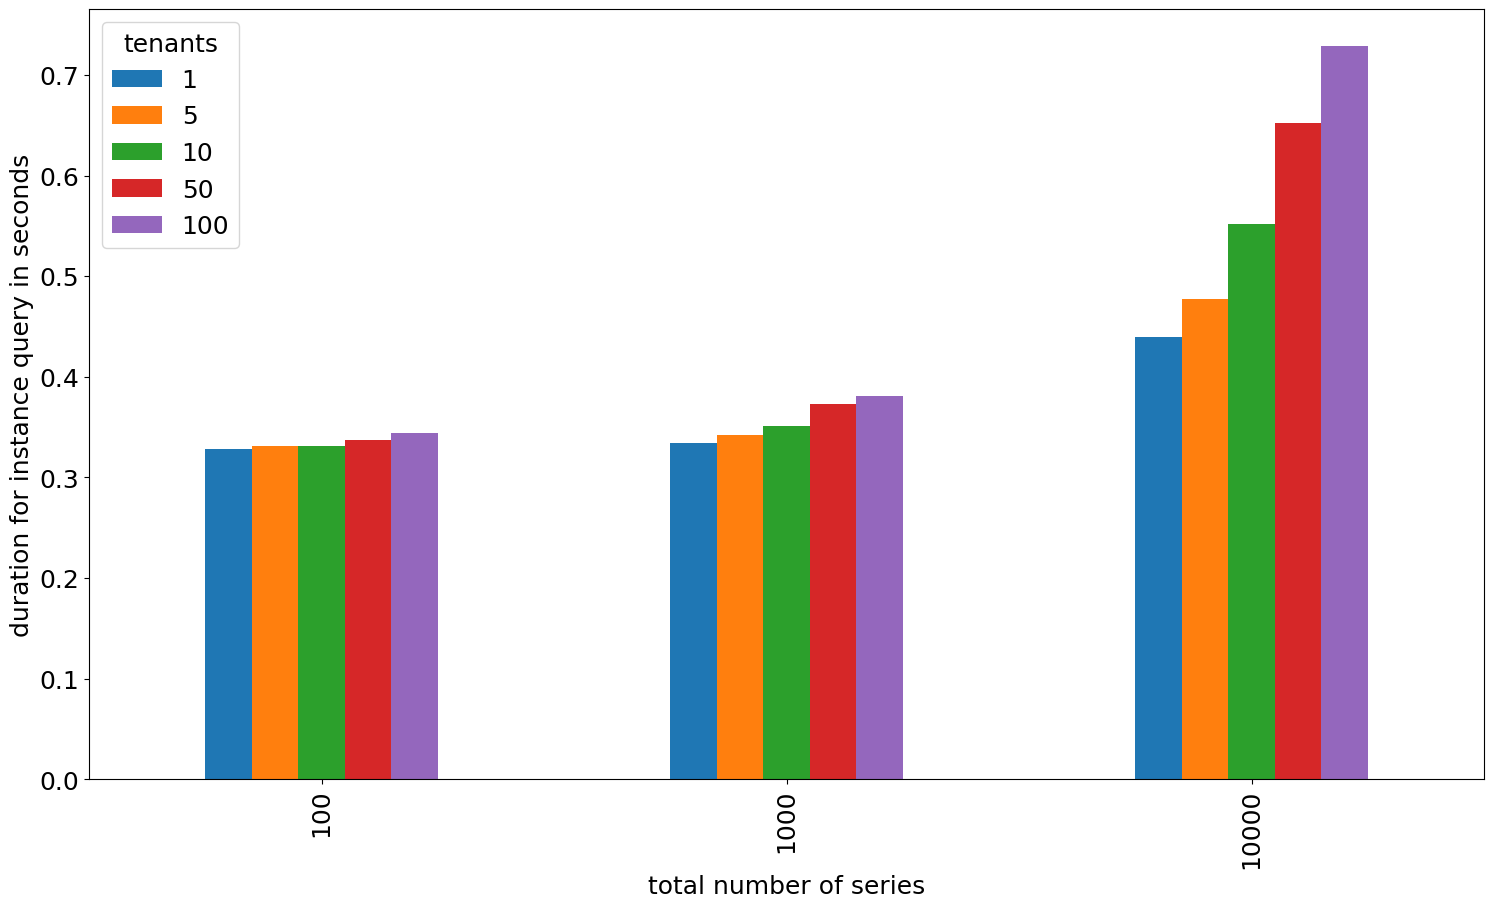

In [20]:
def double_std(array):
 return np.std(array) * 2

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'font.size': 18}) # must set in top


result = pd.pivot_table(
    pd.concat(results_100+results_1000+results_10000),
    values="duration",
    index="name",
    columns="tenants",
    aggfunc=np.mean,
)
ax = result.plot(kind="bar",title='', fontsize=18, figsize=(18, 10), ylabel='duration for instance query in seconds', xlabel='total number of series')

print(ax.get_figure().savefig('figure.svg',transparent=True))
